
In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>
</pre>

In [ ]:
#in this assignment you need two files reviews.csv and tokenization file
#you can use gdown module to import both the files in colab from Google drive
#the syntax is for gdown is !gdown --id file_id
#please run the below cell to import the required files


In [1]:
'''!gdown --id 1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
!gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9'''

/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
To: /home/josephnadar1998/BERT/Reviews.csv
100%|████████████████████████████████████████| 301M/301M [00:04<00:00, 69.8MB/s]
/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13exfXiyiByluh1PfYK1EyZyizqxeCVG9
To: /home/josephnadar1998/BERT/tokenization.py
100%|██████████████████████████████████████| 17.3k/17.3k [00:00<00:00, 21.1MB/s]


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import pickle

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [4]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [5]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
#get only 2 columns - Text, Score
#drop the NAN values
print(reviews[['Text','Score']].info())
print('*'*50)
print('Shape before dropping NA',reviews[['Text','Score']].shape)

review_text=reviews[['Text','Score']].dropna(axis=0)

print('Shape after dropping NA',review_text.shape)

#if score> 3, set score = 1
#if score<=2, set score = 0
#if score == 3, remove the rows. 

review_text.loc[review_text['Score']<=2,'Score']=0
review_text.loc[review_text['Score']>3,'Score']=1
review_text=review_text.drop(review_text[review_text['Score']==3].index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    568454 non-null  object
 1   Score   568454 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ MB
None
**************************************************
Shape before dropping NA (568454, 2)
Shape after dropping NA (568454, 2)


In [7]:
review_text[review_text['Score']==3]

,Text,Score


In [8]:
reviews=review_text
review_text.shape

(525814, 2)

<font size=4>Grader function 2 </font>

In [9]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [10]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [11]:
import re
x='I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most <Hope><>.'
pattern=r'<.+>'
re.sub(pattern,'',x,flags=re.I|re.M)


'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most .'

In [12]:
#remove HTML from the Text column and save in the Text column only
import re

def text_preprocess(x):
  pattern=r'<.+>'
  a=re.sub(pattern,'',x,flags=re.I|re.M)
  return a

reviews['Text']=reviews['Text'].apply(text_preprocess)

In [13]:
#print head 5
reviews.head(5)

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


In [14]:
#saving to disk. if we need, we can load preprocessed data directly. 
#reviews.to_csv('preprocessed.csv', index=False)

In [3]:
reviews=pd.read_csv('preprocessed.csv')
reviews.head(3)

,Text,Score,len
0,The tea was of great quality and it tasted lik...,1,30
1,My cat loves this. The pellets are nice and s...,1,31
2,Great product. Does not completely get rid of ...,1,41


In [4]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 
from sklearn.model_selection import train_test_split
x=reviews.drop('Score', axis=1)
y=reviews['Score']

<AxesSubplot: >

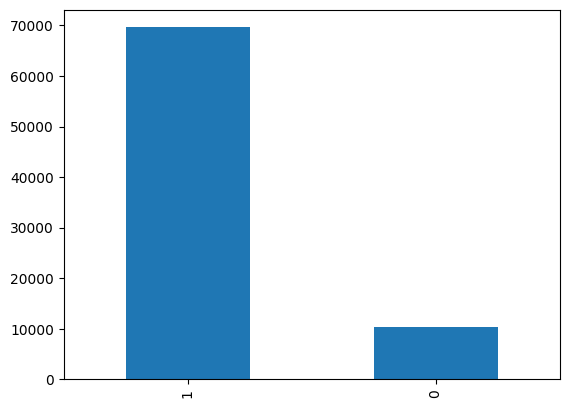

In [16]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar')

<AxesSubplot: >

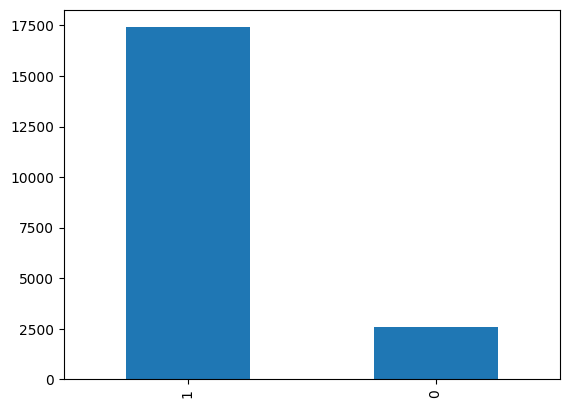

In [17]:
y_test.value_counts().plot(kind='bar')

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [5]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [9]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [7]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [8]:
import tokenization #We have given tokenization.py file

In [9]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case)

In [10]:
# if you are getting error for sentencepiece module you can install it using below command while running this cell for the first time
#!pip install sentencepiece
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

<font size=4>Grader function 3 </font>

In [25]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [26]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

x_train['Text']=x_train['Text'].astype(str)
x_test['Text']=x_test['Text'].astype(str)

X_train_tokens=x_train['Text'].apply(tokenizer.tokenize)
X_test_tokens=x_test['Text'].apply(tokenizer.tokenize)

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 
def preprocess(x):
    tokens=x[:(max_seq_length-2)]
    tokens=['[CLS]',*tokens,'[SEP]']
    return tokens

X_train_tokens=X_train_tokens.apply(preprocess)
X_test_tokens=X_test_tokens.apply(preprocess)

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)
def padding(x):
    if len(x)>max_seq_length:
        a=x[:max_seq_length]
        a=np.array([*a,'[SEP]'])
        
    elif len(x)<max_seq_length:
        a=x.copy()
        pad=[]
        for i in range((max_seq_length-len(x))):
            pad.append('[PAD]')
        a=np.array([*a,*pad])
    else:
        a=x
    return a

X_train_tokens=X_train_tokens.apply(padding)
X_test_tokens=X_test_tokens.apply(padding)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask
def masking(x):
    mask=[]
    for tokens in x:
        if tokens=='[PAD]':
            mask.append(0)
        else:
            mask.append(1)
    return np.array(mask)

X_train_mask=X_train_tokens.apply(masking)
X_test_mask=X_test_tokens.apply(masking)

X_train_tokens=X_train_tokens.apply(tokenizer.convert_tokens_to_ids)
X_test_tokens=X_test_tokens.apply(tokenizer.convert_tokens_to_ids)

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)
X_train_segment=np.zeros((len(X_train_tokens),55))
X_test_segment=np.zeros((len(X_test_tokens),55))

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

In [27]:
X_train_tokens=X_train_tokens.values
X_train_tokens=np.array([np.array(i) for i in X_train_tokens])

X_test_tokens=X_test_tokens.values
X_test_tokens=np.array([np.array(i) for i in X_test_tokens])

X_train_mask=X_train_mask.values
X_train_mask=np.array([np.array(i) for i in X_train_mask])

X_test_mask=X_test_mask.values
X_test_mask=np.array([np.array(i) for i in X_test_mask])

X_test_segment
X_train_segment

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
print(type(X_train_tokens),X_train_tokens.shape)
print(type(X_train_mask),X_train_mask.shape)
print(type(X_test_segment),X_test_segment.shape)

<class 'numpy.ndarray'> (80000, 55)
<class 'numpy.ndarray'> (80000, 55)
<class 'numpy.ndarray'> (20000, 55)


#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [30]:
##save all your results to disk so that, no need to run all again. 
#import pickle
#.dump((x_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
#pickle.dump((x_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [11]:
#you can load from disk
import pickle
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [11]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [13]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [33]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [34]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [35]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
#this cell will take some time to execute, make sure thay you have stable internet connection
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

2500/2500 [==============================] - 317s 125ms/step


In [36]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

625/625 [==============================] - 78s 125ms/step


In [37]:
##save all your results to disk so that, no need to run all again. 
#pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [14]:
#pickle.dump((x_train,y_train),open('training_data.pkl','wb'))
#pickle.dump((x_test,y_test),open('testing_data.pkl','wb'))

In [12]:
X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))
#x_train,y_train= pickle.load(open('training_data.pkl', 'rb'))
#x_test,y_test = pickle.load(open('testing_data.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [13]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric. Do not use tf.keras.metrics.AUC</b> 
<b> You have to write custom code for AUC and print it at the end of each epoch</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [14]:
num_of_class=2
y_train=tf.keras.utils.to_categorical(y_train, num_of_class)
y_test=tf.keras.utils.to_categorical(y_test, num_of_class)

In [15]:
from sklearn.model_selection import train_test_split
x_train_1, x_cv, y_train_1, y_cv=train_test_split(X_train_pooled_output,y_train, test_size=0.2)

In [16]:
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, LSTM
from tensorflow.keras import Model

In [22]:
##create an Neural Network and train your model on X_train_pooled_output and y_train
# you can start as follows
input_layer=Input(shape=(X_train_pooled_output.shape[1],1))
layer_1=LSTM(32,return_sequences=True)(input_layer)
layer_1=Flatten()(layer_1)
layer_1=tf.keras.layers.BatchNormalization()(layer_1)
layer_2=Dense(64,'relu',kernel_initializer=tf.keras.initializers.HeNormal(10))(layer_1)
layer_3=Dropout(0.3)(layer_2)
layer_4=Dense(32,'relu',kernel_initializer=tf.keras.initializers.HeNormal(30))(layer_3)
layer_5=Dense(16,'relu',kernel_initializer=tf.keras.initializers.HeNormal(40))(layer_4)
layer_6=Dense(8,'relu',kernel_initializer=tf.keras.initializers.HeNormal(60))(layer_5)
layer_6=Dense(2,'relu',kernel_initializer=tf.keras.initializers.HeNormal(60))(layer_6)

output=Dense(2,activation='sigmoid')(layer_6)

model=Model(inputs=input_layer, outputs=output)

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 768, 32)           4352      
                                                                 
 flatten (Flatten)           (None, 24576)             0         
                                                                 
 batch_normalization (BatchN  (None, 24576)            98304     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                1572928   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                           

In [17]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)

class_weights

array([3.84733764, 0.57468622])

In [18]:
cl={0:class_weights[0],1:class_weights[1]}

In [23]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class RocCallback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict(self.x, batch_size=128)
        roc_train = roc_auc_score(self.y, y_pred_train)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [21]:
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [34]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

paths='saved_models/final_models/f_model.hdf5'

checkpoint_save = tf.keras.callbacks.ModelCheckpoint(paths, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
training_data=(x_train_1,y_train_1)
validation_data=(x_cv,y_cv)

#auc=RocCallback(training_data,validation_data )

In [ ]:
#https://stackoverflow.com/questions/55968792/why-do-my-models-keep-getting-exactly-0-5-auc

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss='categorical_crossentropy', metrics=[auc,'accuracy'])

In [35]:
model.fit(x_train_1,y_train_1,epochs=30,batch_size=64,class_weight=cl,validation_data=(x_cv,y_cv), callbacks=[learning_rate_reduction,checkpoint_save])

Epoch 1/30
 999/1000 [============================>.] - ETA: 0s - loss: 0.4442 - auc: 0.8775 - accuracy: 0.7355
Epoch 1: val_auc improved from -inf to 0.93819, saving model to saved_models/final_models/f_model.hdf5
1000/1000 [==============================] - 43s 40ms/step - loss: 0.4440 - auc: 0.8777 - accuracy: 0.7357 - val_loss: 0.3869 - val_auc: 0.9382 - val_accuracy: 0.8116 - lr: 1.0000e-04
Epoch 2/30
1000/1000 [==============================] - ETA: 0s - loss: 0.3446 - auc: 0.9304 - accuracy: 0.8230
Epoch 2: val_auc improved from 0.93819 to 0.94464, saving model to saved_models/final_models/f_model.hdf5
1000/1000 [==============================] - 24s 24ms/step - loss: 0.3446 - auc: 0.9304 - accuracy: 0.8230 - val_loss: 0.3442 - val_auc: 0.9446 - val_accuracy: 0.8314 - lr: 1.0000e-04
Epoch 3/30
 998/1000 [============================>.] - ETA: 0s - loss: 0.3234 - auc: 0.9391 - accuracy: 0.8410
Epoch 3: val_auc improved from 0.94464 to 0.94483, saving model to saved_models/final_m

InvalidArgumentError: Graph execution error:

Detected at node 'EagerPyFunc' defined at (most recent call last):
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 530, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_13167/1570016512.py", line 5, in <module>
      model.fit(x_train_1,y_train_1,epochs=30,batch_size=64,class_weight=cl,validation_data=(x_cv,y_cv), callbacks=[learning_rate_reduction,checkpoint_save])
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1028, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1122, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 691, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/tmp/ipykernel_13167/618321739.py", line 4, in auc
      return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)
Node: 'EagerPyFunc'
ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.
Traceback (most recent call last):

  File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_ranking.py", line 580, in roc_auc_score
    return _average_binary_score(

  File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_base.py", line 118, in _average_binary_score
    score[c] = binary_metric(y_true_c, y_score_c, sample_weight=score_weight)

  File "/home/josephnadar1998/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_ranking.py", line 339, in _binary_roc_auc_score
    raise ValueError(

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.


	 [[{{node EagerPyFunc}}]] [Op:__inference_train_function_65566]

In [27]:
#The error occuring above is because at some point the batch selected in the model to calculate AUC is selecting data points of single class.
model.load_weights('saved_models/final_models/f_model.hdf5')

In [33]:
y_pred_test=model.predict(X_test_pooled_output, batch_size=1)

20000/20000 [==============================] - 198s 10ms/step


In [35]:
print(auc(y_test[:,1],y_pred_test[:,1]))

tf.Tensor(0.9607595314284852, shape=(), dtype=float64)


<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a> </pre>


In [ ]:
#there is an alterante way to load files from Google drive directly to your Colab session
# you can use gdown module to import the files as follows
#for example for test.csv you can write your code as !gdown --id file_id (remove the # from next line and run it)

In [36]:
#read the csv file
test_df= pd.read_csv('test.csv')

<Pre>1. You have to write a function that takes the test_df,trained model and the required parameters as input. 
2. Perform all the preproceesing steps inside the function.
- Remove all the html tags
- Now do tokenization [Part 3 as mentioned above]
- Create tokens,mask array and segment array
- Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
- Print the shape of output(X_test.shape).You should get (352,768)
3. Predict the output of X_test with the neural network model which we trained earlier.

4. Return the occurences of class labels from the function.
The output should be the count of datapoints classified as 1 or 0.

</pre>

In [50]:
import re
def final_model(df,model):
    #Dropping NA values
    df=df.dropna()
    
    #Renaming the dataframe to x_test
    x_test=df['Text'].copy()
    
    def html_tag_remover(x):
        pattern=r'<.+>'
        a=re.sub(pattern,'',x)
        return a
    
    x_test=x_test.apply(html_tag_remover)
    
    x_test=x_test.astype(str)
    
    def preprocess(x):
        tokens=x[:(max_seq_length-2)]
        tokens=['[CLS]',*tokens,'[SEP]']
        return tokens
    
    x_test_tokens=x_test.apply(tokenizer.tokenize)
    x_test_tokens=x_test_tokens.apply(preprocess)
    
    def padding(x):
        if len(x)>max_seq_length:
            a=x[:max_seq_length]
            a=np.array([*a,'[SEP]'])
        
        elif len(x)<max_seq_length:
            a=x.copy()
            pad=[]
            for i in range((max_seq_length-len(x))):
                pad.append('[PAD]')
            a=np.array([*a,*pad])
        else:
            a=x
        return a
    
    x_test_tokens=x_test_tokens.apply(padding)
    
    def masking(x):
        mask=[]
        for tokens in x:
            if tokens=='[PAD]':
                mask.append(0)
            else:
                mask.append(1)
        return np.array(mask)
    
    
    x_test_mask=x_test_tokens.apply(masking)
    x_test_tokens=x_test_tokens.apply(tokenizer.convert_tokens_to_ids)
    
    #converting to numpy arrays
    x_test_mask=np.array([np.array(i) for i in x_test_mask])
    x_test_tokens=np.array([np.array(i) for i in x_test_tokens])
    x_test_segment=np.ones(x_test_tokens.shape)
    print(x_test_segment.shape)
    x_test_bert_output=bert_model.predict([x_test_tokens,x_test_mask,x_test_segment])
    
    y_pred_test=model.predict(x_test_bert_output, batch_size=1)
    return y_pred_test

In [51]:
y_test_pred=final_model(test_df,model)

(352, 55)
352/352 [==============================] - 5s 15ms/step


In [63]:
p_values_test=y_test_pred[:,1]
p_values_test[p_values_test>=0.5]=1
p_values_test[p_values_test<0.5]=0

In [68]:
import random
for values in range(20):
    n=random.sample(range(len(p_values_test)),1)
    print(test_df['Text'].values[n])
    print(p_values_test[n])
    print('*'*50)

['Love them, very "gingery".  Great with your favorite tea or coffee.  Love that they are using natural ingredients.']
[1.]
**************************************************
['My husband puts this on everything. It is very expensive to buy in the grocery store and it comes in a small bottle. This bottle is huge. It is a great buy. There is enough to bottle and give away to others.']
[1.]
**************************************************
['I bought this popcorn when my in laws got me a popcorn maker for christmas.  This popcorn is BETTER then movie theater popcorn!  I will definitely be buying more once I run out!']
[1.]
**************************************************
['These were nummy!  a bit over priced for one pound of nuts - but the quality is truly there! :)<br />I would order again!']
[1.]
**************************************************
['We enjoy the taste and, having flax in it, is good for you. We can take care of our bodies and like the taste. A win-win!']
[0.]
******

## Please write your observations at the end of notebook and  explain each and every step you followed in solving this assignment.

### Observations and Approach Taken:
- As a first step, I watched all the lectures on BERT and then read through the blog, mentioned in the notebook to understand, how the classification is done using BERT Model.
- Then I started following the instructions as mentioned in the Notebook.